## Expected Goals Prediction Using Machine Learning 

Expected Goals, or xG, is a common stat used in advanced hockey analytics as a metric for evaluating the quality of a shot taken by a team or player. To understand xG, let's first consider a foundational metric: Corsi

#### Corsi
Corsi is a straightforward metric that reprents the net value of shots attempts towards goal (on target, missed and blocked shots) taken for vs shots taken against represented as a single plus-minus value. For example, if  player was on the ice and generated 10 shots on net, while only conceding 8 shots while they were on the ice, the player's Corsi would be +2. 

The reason Corsi is such a key element of advanced hockey analytics is that shot attempt differential is a better predictor of future goal differential than past goal differential [[1]](https://theathletic.com/121980/2017/10/09/an-advanced-stat-primer-understanding-basic-hockey-metrics/). For example, a player with a good plus-minus, but poor Corsi rating is expected to regress in the future, and similarly, a team with a poor goal differential but a positive Corsi is expected to improve.

So if we have Corsi, why do we need Expected Goals? One key drawback to Corsi (and Fenwick: same as Corsi but no blocked shots considered), is that it does not take into account quality of shots. For example, one team may be outshooting their opponent, but all shots are taken from the perimeter with no traffic in front of the opposing team's goalie. On the contrary, the team being outshot has produced danger shot attempts from close to the net and on breakaways. These factors are what XG attempts to address.

#### Expected Goals (xG)

The models for xG account for shot location (distance, angle) and also circumstantial variables such as rebounds and rush chances. Each shot is given a weight based on the likelihood that the unblocked shot will result in a goal. For example, a shot from the point may have a score of 0.05, and a rebound chance in close to the net may have a score of 0.4. This addresses the concern with Corsi and Fenwick that not all shots are created equal.

There is some debate about whether or not xG is actually a better future predictor of expected goal differential than Corsi, but the two metrics in tandem can be quite insightful.

---

In this notebook, we will develop simple xG goal model based on shot location (distance, and then distance + angle) using Logistic regression, SVMs and gradient boosted decision tree models. As mentioned above, this could be extended to include information such as rebounds, one-timers, rush chances, etc., but it has been shown that simple models with distance and angle as features perform reasonably well compared to models with higher complexity [[2]](https://www.youtube.com/watch?v=TENd93QJt-8&t=2914s&ab_channel=ColumbusBlueJackets).

First, lets install the necessary packages for working with the MongoDB client:

In [1]:
# first install dnspython3, then uninstall dnspython, then install dnspython=2.1.0
# (otherwise keyword error with pymongo)
# solution from https://github.com/dcrosta/flask-pymongo/issues/133
! python3 -m pip install dnspython3
! python3 -m pip uninstall dnspython
! python3 -m pip install dnspython==2.1.0
# Instaling PyMongo, this is the interface to connect to MongoDB with Python
! python3 -m pip install pymongo==3.11.1

     |████████████████████████████████| 177 kB 5.4 MB/s 
  Created wheel for dnspython3: filename=dnspython3-1.15.0-py3-none-any.whl size=1773 sha256=70df892c6f4fd8a7caf15828084f13214d5f36e794817adc9ea0e9e16c5565b8
  Stored in directory: /root/.cache/pip/wheels/c5/fc/16/b44ba69b05b6b2d072965ccdad69341d012e36c3971ae119fa
Successfully built dnspython3
Found existing installation: dnspython 1.15.0
Uninstalling dnspython-1.15.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/dns/*
    /usr/local/lib/python3.7/dist-packages/dnspython-1.15.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled dnspython-1.15.0
     |████████████████████████████████| 241 kB 5.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dnspython3 1.15.0 requires dnspython==1.15.0, but you have dnspython 2.1.0 which is incompatible.
     |████████████████████████████████| 512

Import necessary libraries and setup plot parameters.

In [2]:
import pymongo
from pymongo import MongoClient
from pymongo import MongoClient
import os
import numpy as np
import math as m
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import certifi
from matplotlib.path import Path
from zlib import crc32

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/hockey_analytics')
import config

# define path to background images
fig_dir = '/content/drive/MyDrive/hockey_analytics/figures'
bg_filename = 'full_ice_scale_mm.png'
bg_path = os.path.join(fig_dir,bg_filename)

# define plot parameters
plt.rcParams['font.family'] = 'Sans serif'
plt.rcParams['font.weight'] = 'light'
plt.rcParams['font.stretch'] = 'normal'
plt.rcParams['font.size'] = 12
marker = 's'
shot_ms = 45 # shot marker size

# coordinates of vertices for high danger 'home plate' region
home_plate_coords = {'x': [54, 54, 68, 89, 89, 68],
                     'y': [-24, 24, 24, 9.5, -9.5, -24]}

# list of hex colors for shots, missed shots and goals in that order
# ----- home -----
c_h = ['#4E6587', '#EDECF1', '#324157']
ec_h = ['#4E6587', '#4E6587', '#324157']
# ---- away -----
c_a = ['#87704E', '#F0F1EC', '#64412B']
ec_a = ['#87704E','#87704E', '#64412B']


Mounted at /content/drive


Define helper functions for computing shot distance and angle from a given set of x-y coordinates:

In [3]:
def calc_distance(row):
    return np.sqrt((row['x']-coords_net[0])**2 + (row['y']-coords_net[1])**2)

def calc_angle(row):
    dx = row['x'] - coords_net[0]
    dy = abs(row['y'] - coords_net[1])
    return np.arctan2(dx,dy)*180/m.pi


Connect to the MongoDB client and define pointers to the relevant database and collections:

In [4]:
#%% ----- LOAD DATA FROM DB -----
# connect to mongodb database
uri = config.mongoDB_uri
client = MongoClient(uri) #, tlsCAFile=certifi.where())
db_cursor = client.game_events
plays_collection = db_cursor.rs_1920_plays
boxscores_collection = db_cursor.rs_1920_boxscores

Define a query to extract events that are goals, shots, and missed shots:

*Aside*: though not required for this model, blocked shots can also be extracted. However, the blocked shot is recorded from the point at which the shot was blocked, not where the shot was taken. As a result, a large number of blocked shots appear close to the net and would artificially inflate the 'quality' of the shot chance. 

In [5]:
# start with basic query to collect goals, shots and missed shots regardless of 
# strength - exclude empty net goals
pipeline = [{'$unwind': '$allPlays'},
		{'$project': {
			'event': '$allPlays.result.event',
			'shooter': { '$arrayElemAt': [ '$allPlays.players.player.fullName' , 0 ] },
			'team': '$allPlays.team.triCode',
			'x': '$allPlays.coordinates.x',
			'y': '$allPlays.coordinates.y',
			'period': '$allPlays.about.period',
            'empty_net': '$allPlays.result.emptyNet'
			}
		},
		{'$match': {
			'$and': [{
				'$or': [
					{'event': 'Shot'},
					{'event': 'Missed Shot'},
					{'event': 'Goal'}
				]},
			{'empty_net': {'$ne': 'true'}}
			]}
		}
		]

query_shots = list(plays_collection.aggregate(pipeline))
client.close()

Overlay all shots (on target, missed shots, and goals) onto the rink to visualize the spatial distribution of shots

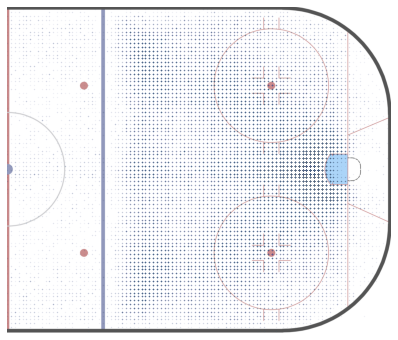

In [6]:
#%% ----- PLOT SHOTS OVERLAID ON RINK -----
# -----------------------------------------------------------------------------
# convert shots to data frame for transformations
df_shots = pd.DataFrame(query_shots)

# transform coordinates to have all shots on same side for each team
df_shots.loc[df_shots.x <= 0, ['x','y']] *= -1

# load rink image
img_bg = plt.imread(bg_path)

# rink extents
rink_bg_extents = [-100, 100, -42.5, 42.5]

# plot shots overlaid on rink
f = plt.figure(figsize = (10,6))
ax = f.add_subplot(1,1,1)
ax.imshow(img_bg, extent = rink_bg_extents)
ax.scatter(df_shots['x'], df_shots['y'], 
             s = 0.1, c = c_h[0], ec = ec_h[0], alpha = 0.1)
ax.set_aspect(1)
ax.set(xlim=(0, 100), ylim=(-42.5, 42.5))
ax.axis('off')
plt.show()

Let's define the target as a goal occurring (1) or not occurring (0). We will also add features such as distance (distance of shot from center of the net) and angle (angle of shot relative to the middle of the ice). We should get an understanding of the number of instances in each class and the distribution within each class as this will help guide model selection.

In [7]:
# -----------------------------------------------------------------------------
# ----- add features -----
# -----------------------------------------------------------------------------
# single var prediction: distance from net
coords_net = [89,0]
    
data_df = df_shots.copy()
data_df.dropna(subset = ['x', 'y'], inplace=True)
# remove shots below the goal line
data_df = data_df[data_df['x'] <= coords_net[0]]
# compute distance in feet to net for each shot
data_df['distance'] = data_df.apply(calc_distance, axis=1)
data_df['angle'] = data_df.apply(calc_angle, axis = 1)

# assign target (goal or not)
data_df['target'] = data_df['event'].apply(lambda x: 1 if x == 'Goal' else 0)

# print number of instances in each class
goals = len(data_df[data_df['target'] == 1])
miss = len(data_df[data_df['target'] == 0])

print('Goals: '+str(goals))
print('Miss: '+str(miss))

Goals: 6601
Miss: 86507


Now plot a subset of shots that are color-coded based on goal or save/miss to try and get an idea of where most goals are occurring:


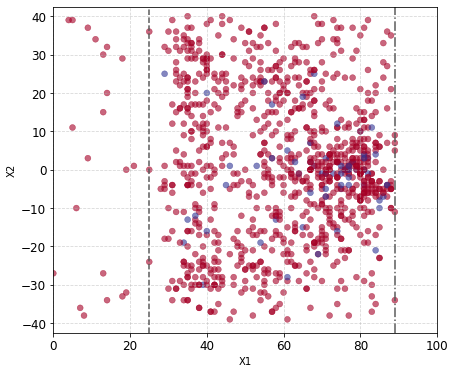

In [8]:
# select 1,000 random samples
sample_data = data_df.sample(n = 1000, random_state = 1)

# create lines to indicate the blue line and goal lines for visualization
y_bl = np.linspace(-42.5, 42.5, num = 10)
x_bl = 25*np.ones(y_bl.shape)

y_gl = np.linspace(-42.5, 42.5, num = 10)
x_gl = 89*np.ones(y_bl.shape)

# plot shots overlaid on rink
plt.figure(figsize = (10,6))
plt.scatter(sample_data['x'], sample_data['y'], c = sample_data['target'], 
             cmap = plt.get_cmap('RdYlBu'), linewidth = 0.5, s = 35 , 
             alpha = 0.6)
plt.plot(x_bl, y_bl, linewidth = 1.5, linestyle = '--', c = '#595959')
plt.plot(x_gl, y_gl, linewidth = 1.5, linestyle = '-.', c = '#595959')
plt.gca().set_aspect(1)
plt.xlabel('X1', fontsize = 10)
plt.ylabel('X2', fontsize = 10)
plt.gca().set(xlim=(0, 100), ylim=(-42.5, 42.5))
plt.grid(True, alpha = 0.5, linestyle = '--', zorder = 0)
plt.show()

We can clearly see that these two classes are not linearly separable. The majority of shots are taken within about 20 ft of the net, or around X1 = 40 ft, which corresponds to the typical locations where defenceman shoot from. The majority of goals (blue) tend to be focussed around the middle of the ice (X2 = 0) and closer towards the goal within the attacking zone (X1 > 60). 





Let's now check the distribution of the positive and negative classes:

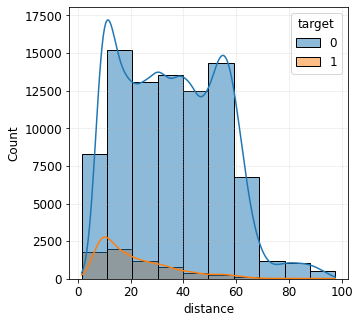

In [9]:
import seaborn as sns
plt.figure(figsize = (5,5))
sns.histplot(data = data_df, x = 'distance', kde=True, bins=10, hue='target')
plt.grid(True, alpha = 0.5, linestyle = '--', linewidth = 0.5 )


We can see that neither distribution is normal and in particular, goals is skewed right. This imposes some restrictions on the types of models we can use for prediction. For example, Linear Discrimant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) assume that the distributions are Gaussian. We can account for the skewed distribution using Naive Bayes, or use several other models that make no assumptions about the distribution of the data within each class such as: logistic regression, K-Nearest Neighbours (K-NN), or Support Vector Machines (SVMs).

In this notebook we will first consider logistic regression and evaluate the model performance, before examining Naive Bayes, and SVMs. The advantage of logistic regression and Naive Bayes is that we can extract probabilities for affiiliation with each class. With SVMs we do not have access to probabilities but we can apply other powerful tools, such as the kernel trick, to transform the data into higher dimensional spaces where the two classes may be more separable than compared to the 2D x-y system.

--- 

#### Fit a univariate logistic regression model

To start, let's fit a simple logistic regression model to predict whether or not a goal will occur based on shot distance.

In this case, we have imbalanced classes so we will use stratified random sampling to ensure that each class is proprtionally represented in the training, validation and testing sets.

In [10]:
# -----------------------------------------------------------------------------
# ----- divide into train, test and validate sets -----
# -----------------------------------------------------------------------------
# use random_state to ensure same points assigned each time the data is loaded
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.1

# define features and target for model training
features = ['distance']
target = ['target']

# stratified random sampling so that goals are proportionally represented
strat_split_test = StratifiedShuffleSplit(n_splits = 1, test_size = test_ratio, random_state = 1)
strat_split = StratifiedShuffleSplit(n_splits = 1, test_size = validation_ratio, random_state = 2)

# define features and target
X_all = data_df
y_all = data_df[target].squeeze()

# define test and combined train/validation (trnval) set
for trnval_index, test_index in strat_split_test.split(X_all, y_all):
    X, X_test = X_all.iloc[trnval_index], X_all.iloc[test_index]
    y, y_test = y_all.iloc[trnval_index], y_all.iloc[test_index]

# define train and validation sets
for train_index, val_index in strat_split.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# check proportions of goals and misses in the validation set
print('Check proportions of goals in the train, validation and test sets:')
print('Train:')
print(y_train.value_counts()/len(y_train))
print('Validation:')
print(y_val.value_counts()/len(y_val))
print('Test:')
print(y_test.value_counts()/len(y_test))

Check proportions of goals in the train, validation and test sets:
Train:
0    0.9291
1    0.0709
Name: target, dtype: float64
Validation:
0    0.929117
1    0.070883
Name: target, dtype: float64
Test:
0    0.929116
1    0.070884
Name: target, dtype: float64


Define the model, train it based on shot distance, and make predictions on the training set:

In [11]:
# -----------------------------------------------------------------------------
# ----- define model, train and predict -----
# -----------------------------------------------------------------------------
# fit a basic logistic regression model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train[features], y_train)

# predict probability for each training instance
y_prob = log_reg.predict_proba(X_train[features])
# predict class based on default 0.5 decision boundary
y_pred = log_reg.predict(X_train[features])
# predict socres for each training instance
y_scores = log_reg.decision_function(X_train[features])

Plot the two classes verses distance along with the predicted outcome, and probability of affiliation with the goal class.

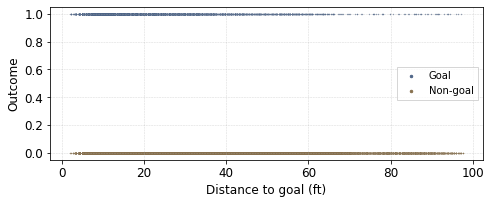

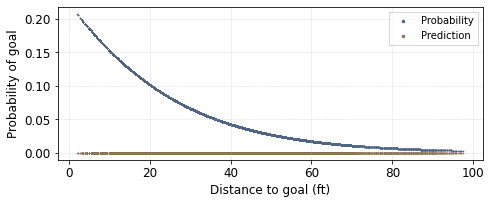

In [12]:
# -----------------------------------------------------------------------------
# ----- plot results -----
# ----------------------------------------------------------------------------
# create plot parameter dictionary
params = dict()
params['figsize'] = (7,3)
params['s'] = 0.1
params['edge_colors'] = [ec_h[0], ec_a[0]]
params['face_colors'] = [ec_h[0], ec_a[0]]
params['xlabel'] = 'Distance to goal (ft)'
params['ylabel'] = 'Outcome'
params['tight_layout'] = True
params['labels'] = ['Goal', 'Non-goal']
params['tight_layout'] = True

# define helper function to generate two-series scatter plots
def plot_two_series_scatter(x0, y0, x1, y1, params):
    # plot goal vs miss
    f = plt.figure(figsize = params['figsize'])
    ax = f.add_subplot(1,1,1)
    ax.scatter(x0, y0, s = params['s'], c = params['face_colors'][0],
               label = params['labels'][0])
    ax.scatter(x1, y1, s = params['s'], c = params['face_colors'][1],
               label = params['labels'][1])
    ax.grid(True, alpha = 0.5, linestyle = '--', linewidth = 0.5 )
    ax.set_xlabel(params['xlabel'])
    ax.set_ylabel(params['ylabel'])
    leg = plt.legend(fancybox=False, fontsize = 10)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [6]
    if params['tight_layout']:    
        plt.tight_layout()

# plot shots outcome vs distance
plot_two_series_scatter(X_train[y_train == 1]['distance'], y_train[y_train == 1], X_train[y_train < 1]['distance'], y_train[y_train < 1], params)

# plot shots outcome vs probability
params['labels'] = ['Probability', 'Prediction']
params['ylabel'] = 'Probability of goal'
plot_two_series_scatter(X_train['distance'], y_prob[:,1], X_train['distance'], y_pred, params)

When we plot the probability and predictions together, we can see that for all instances in the training set are classified as non-goals. This is becuase the default decision boundary is set to a value of 0.5, or a probability of 50%. In this univariate model, the highest probability for a goal is about 0.2 at a distance of approximately 4 ft.  

We have the ability to modify the decision boundary threshold, but to make an informed selection, it is useful to examine the types of errors that the model is making. We can do this through a confusion matrix, which is shown below for the default decision boundary. 

*For reference, TN, FN, TP and FP denote true negatives, false negatives, true positives and false positives, respectively*

In [13]:
#%% ----- EVALUATE MODEL PERFORMANCE -----
# -----------------------------------------------------------------------------
# lets add the predictions to the data frame for evaluating performance
X_train['predict'] = y_pred

true_positives = X_train.loc[((y_pred == 1) & 
                          (y_train == 1)),'predict'].count()

true_negatives = X_train.loc[((y_pred == 0) & 
                          (y_train == 0)),'predict'].count()

print('Decision boundary = 0.5: \nTrue Positives/Negatives: \n TN: {}, TP: {}'.format(true_negatives, true_positives))

# confusion matrix
# note: first row is negative class, second row is positive class
# Cij: observations known to be in class i, and predicted as class j
# format: TN, FP/FN, TP
from sklearn.metrics import confusion_matrix
print('\nConfusion matrix:')
print(confusion_matrix(y_train,y_pred))

Decision boundary = 0.5: 
True Positives/Negatives: 
 TN: 66177, TP: 0

Confusion matrix:
[[66177     0]
 [ 5050     0]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


With the default decision boundary, the confusion matrix shows that there are no positive predictions made, and so the model mis-classifies all 5,050 goals in the training set. This is effectively a trivial model where we always predict a non-goal, which has a baseline accuracy of 93%. This seems like a good performance, but accuracy is not a good metric for skewed datasets, such as this one. Therefore, we will consider other metrics for evaluating performance, such as precision and recall.

Fortuantely, we can extract the scores for each prediction and manually define a different threshold to use. Say we want a classifier with a certain precision (precision = TP/(TP+FP)), say 20%, we can make predictions based on this value instead of the default threshold:

In [14]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

def compute_metrics(y,y_scores, p_thresh):
    # compute precision, recall and thresholds
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    # lets use our precision threshold to make predictions
    threshold_precision = thresholds[np.argmax(precisions >= p_thresh)]

    #now make predictions based on that threshold instead of the default value of 0
    y_pred_thresh = (y_scores >= threshold_precision).astype(int)

    # now look at the confusion matrix, show precision and recall
    print('Confusion matrix ('+str(p_thresh*100)+'% precision threshold):')
    print(confusion_matrix(y, y_pred_thresh))
    print('\nPrecision: {:.3f}'.format(precision_score(y, y_pred_thresh)))
    print('Recall: {:.3f}'.format(recall_score(y, y_pred_thresh)))

    return precisions, recalls, thresholds

precisions, recalls, thresholds = compute_metrics(y_train, y_scores, 0.2)


Confusion matrix (20.0% precision threshold):
[[64339  1838]
 [ 4580   470]]

Precision: 0.204
Recall: 0.093


In this case, the model now correctly predicts 470 goals and 64,339 missed shots (accuracy = 91%), but incorrectly classifies 1838 shots as goals, and classified 4,580 goals as misses. 

The precision (TP/(TP+FP)) of this classifier is 20.4%, which can be interpretted as the ability of the classifier to not mis-label negative samples as positives. The recall (TP/(TP+FN)), or true positive rate (TPR) is 9.3%, which can be interpretted as the ability of the classifier to find all positive samples. Another metric we can consider is the true negative rate (TNR) (TN/(TN+FP)), which for this model is 97.2%.

For each threshold we will have a compromise between precision and recall, and the chosen threshold depends on the application. For example, how important it is to identify all goals (P), and what our tolerance on recall is (recall = TP/ (TP+FN)). The tradeoff between precision and recall is shown below:


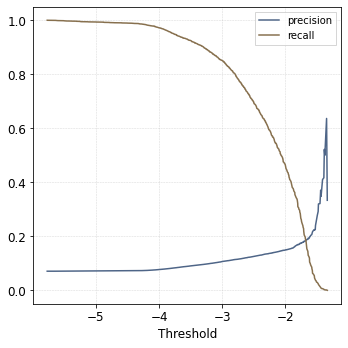

In [15]:
plt.figure(figsize = (5,5))
plt.plot(thresholds, precisions[:-1], linewidth = 1.5, c = ec_h[0], label = 'precision')
plt.plot(thresholds, recalls[:-1], linewidth = 1.5, c = ec_a[0],  label = 'recall')
plt.xlabel('Threshold')
plt.ylabel('')
plt.grid(True, alpha = 0.5, linestyle = '--', linewidth = 0.5 )
plt.legend(fancybox = False, fontsize = 10)
plt.tight_layout()

Selecting the optimal threshold involves a trade-off between the types of errors made by the model, and the tolerance for each type of error depends strongly on the application. The *receiver operating characteristic* curve (ROC) is a common way to visualize the trade-off between TPR and TNR as a function of threshold. This is shown in the figure below against a random choice model (shown in dashed line). We can compute the area under curve (AUC) as a metric for the model (note that the random choice model has an AUC = 0.5).

AUC score: 0.7144180361188573


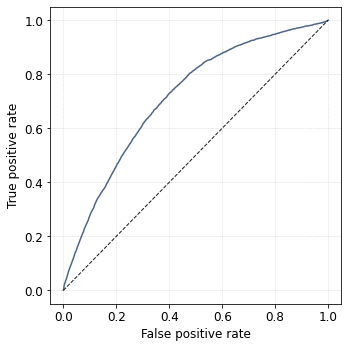

In [16]:
# plot roc curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds  = roc_curve(y_train, y_scores)

f = plt.figure(figsize = (5,5))
ax = f.add_subplot(1,1,1)
ax.plot(fpr, tpr, linewidth = 1.5, c = ec_h[0], label = None)
ax.plot([0,1], [0,1], linestyle = '--', c = '#151b24', linewidth = 1)
ax.grid(True, alpha = 0.5, linestyle = '--', linewidth = 0.5 )
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.grid(True, alpha = 0.5, linestyle = '--', linewidth = 0.5 )
plt.tight_layout()

# get logistic regression auc score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_train, y_scores)
print('AUC score: {}'.format(auc_score))

Ideally, we would want our model to be as close to the top left corner as possible. So in this case, a univariate logistic regression model does not do a great job of predicting goals based on distance alone. 

Before considering other models, lets look at how well this model generalizes to new data using the same 20% precision threshold.



In [17]:
# predict probability for each training instance
y_prob = log_reg.predict_proba(X_test[features])
# predict class based on default 0.5 decision boundary
y_pred = log_reg.predict(X_test[features])
# predict socres for each training instance
y_scores = log_reg.decision_function(X_test[features])

# compute precision and recall metrics
precisions_test, recalls_test, thresholds_test = compute_metrics(y_test,y_scores, 0.2)

auc_score = roc_auc_score(y_test, y_scores)
print('AUC score: {}'.format(auc_score))

Confusion matrix (20.0% precision threshold):
[[8443  208]
 [ 607   53]]

Precision: 0.203
Recall: 0.080
AUC score: 0.7048360147539433


For the test data set, we see that for the same precision, the recall and AUC is lower, which is to be expected since the model was not trained on this data. That said, the drop in performance is not significant. We could run this procedure several times with different stratified random samples to get an idea of the distribution of the performance. 

As a useful visualization, we can create a heatmap of the predicted goal probability overlaid onto the rink: 

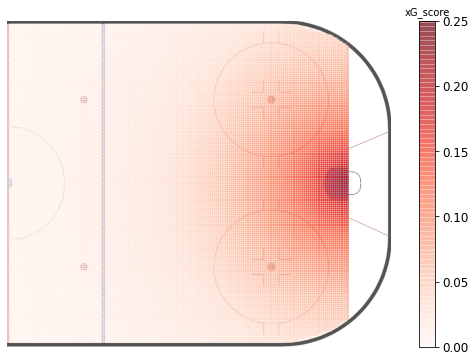

In [18]:
#%% ----- GENERATE XG VS LOCATION -----
# ----------------------------------------------------------------------------

# create a grid of coordinates to evaluate the model
x_eval_vec = np.linspace(0,89,179)
y_eval_vec = np.linspace(-41.5,41.5, 167)
x_eval, y_eval = np.meshgrid(x_eval_vec, y_eval_vec)

rows, cols = x_eval.shape

# compile the coordinates into a dataframe
eval_df = pd.DataFrame()
eval_df['x'] = np.reshape(x_eval, (-1,))
eval_df['y'] = np.reshape(y_eval, (-1,))
eval_df['distance'] = eval_df.apply(calc_distance, axis=1)
eval_df['angle'] = eval_df.apply(calc_angle, axis = 1)

# create a mask for the corners of rink
verts = [
   (74, -41.5),  
   (84, -38.5), 
   (89.1, -35.4),  
   (89.1, 35.4),  
   (84, 38.5),
   (74,41.5),
   (70, 43),
   (90,43),
   (90,-43),
   (74,-42)
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path = Path(verts, codes)

# pass into the model to make a prediction for each location
y_prob_eval = log_reg.predict_proba(eval_df[features])
eval_df['xG_score'] = y_prob_eval[:,1]
eval_df = eval_df.apply(lambda r: np.nan if path.contains_point((np.abs(r.x), r.y)) else r, axis= 1)

xG_score = np.array(eval_df['xG_score']).reshape((rows,cols))

import matplotlib.patches as patches

# plot xGscore overlaid on rink
f = plt.figure(figsize = (10,6))
ax = f.add_subplot(1,1,1)
ax.imshow(img_bg, extent = rink_bg_extents)
pm = ax.pcolormesh(x_eval, y_eval, xG_score, cmap='Reds', vmin=0, vmax=0.25, 
                   alpha = 0.45)
ax.set(xlim=(0, 100), ylim=(-42.5, 42.5))
ax.set_aspect(1)
cbar = f.colorbar(pm, ax = ax)
cbar.ax.set_title('xG_score', fontsize = 10)
ax.axis('off')
plt.show()

This xG probability map aligns with our general intuition that the highest probability of a goal occurs when a shot is taken around the net. However, the model predicts that all shots at the same radius have the same probability of a goal, which is likely not the case in reality. For example, shots take from the center of the ice would be expected to have a higher probability of a goal compared to a shot taken near the goal line. To account for this, we could introduce another feature such as shot angle. We could also take into account strength of play (i.e.: powerplay, even strength, short handed), rebounds or rush chances and this will be considered in another workbook.

## Compare performance against other models

In the future I will compare the performance of the univariate logistic regression against a Naive Bayes model and a SVM.